# Analyse de graphe pour le corpus d'articles scientifiques

In [1]:
# Imports des bibliothèques et modules nécessaires
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx
import community as community_louvain  # Algorithme de Louvain


# Ajouter le répertoire parent au chemin de recherche
sys.path.append(os.path.abspath('..'))

# Import des modules du projet
from src.config.config import load_config
from src.data_acquisition.data_loader import DataLoader
from src.graph_analysis.graph_builder import GraphBuilder
from src.graph_analysis.graph_stats import GraphStats
from src.graph_analysis.graph_viz import GraphVisualizer

## 1. Chargement des données prétraitées

In [2]:
# Chargement de la configuration (par defaut, on peut par exemple en définir une par corpus etc dans le fichier ./config/config.py))
config = load_config()

# Chemin vers le fichier de données
data_path = Path("../data/processed/corpus_preprocessed.json")

# Vérifier si le fichier existe
if not data_path.exists():
    raise FileNotFoundError(f"Le fichier {data_path} n'existe pas.")

# Créer un objet DataLoader
data_loader = DataLoader(config)

# Charger les données
cleaned_docs = data_loader.load_from_json(data_path)

# Afficher les premières lignes
pd.DataFrame(cleaned_docs).head()

,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,purpose study develop learning tool high schoo...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,visual analytics science and technology,paper describes design implementation methodol...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,pattern recognition and machine intelligence,article applied garch model instead ar arma mo...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,international conference on computer graphics ...,,"[Rafael Álvarez, Leandro Tortosa, José-Francis...",0,[],COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,international symposium on computer and inform...,,"[Guzin Ulutas, Mustafa Ulutas, Vasif V. Nabiyev]",0,"[5626736c-e434-4e2d-8405-54940fab88ab, 8e87e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8


## 2. Construction du graphe de citation

In [9]:
# Créer un objet GraphBuilder
graph_builder = GraphBuilder(cleaned_docs)

# Construire le graphe de citation
print("Construction du graphe de citation...")
citation_graph = graph_builder.build_citation_graph()

# Afficher des informations sur le graphe
print(f"Graphe construit avec {citation_graph.number_of_nodes()} nœuds et {citation_graph.number_of_edges()} arêtes")

# Vérifier si des arêtes ont été créées
if citation_graph.number_of_edges() == 0:
    print("Attention: Aucune arête n'a été créée. Vérifiez les références dans vos données.")

Construction du graphe de citation...
Graphe construit avec 40596 nœuds et 3641 arêtes.
Graphe construit avec 40596 nœuds et 3641 arêtes


## 3. Statistiques de base sur le graphe

Statistiques de base du graphe:
- num_nodes: 40596
- num_edges: 3641
- density: 2.2093518727627886e-06
- is_connected: False
- num_connected_components: 40572
- average_clustering: 0.004982536257785051
- diameter: 1


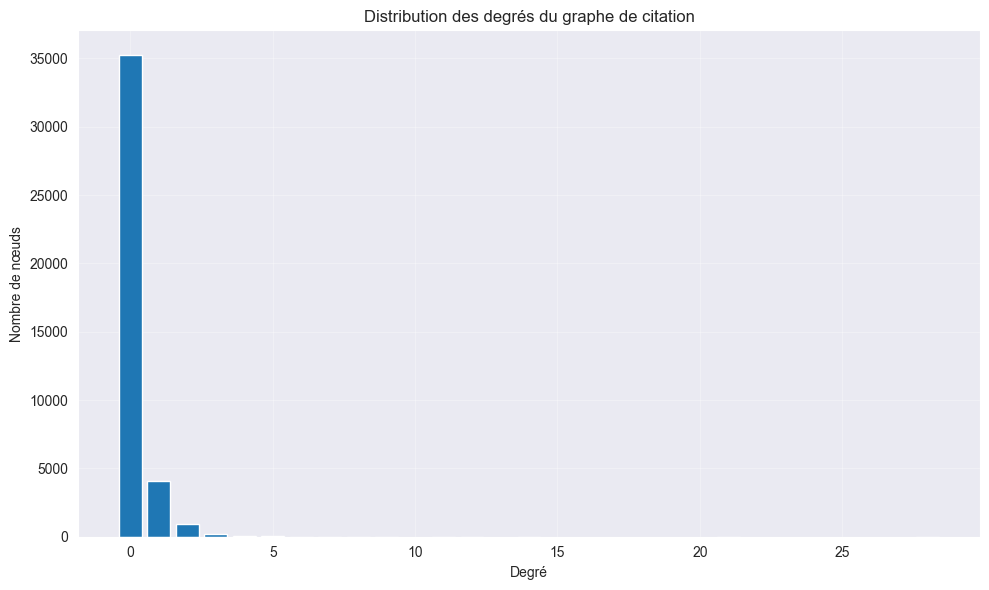

In [5]:
# Créer un objet GraphStats
graph_stats = GraphStats(citation_graph)

# Calculer les statistiques de base
basic_stats = graph_stats.compute_basic_stats()

# Afficher les statistiques
print("Statistiques de base du graphe:")
for key, value in basic_stats.items():
    print(f"- {key}: {value}")

# Calculer la distribution des degrés
degree_dist = graph_stats.get_degree_distribution()

# Convertir en DataFrame pour la visualisation
degree_df = pd.DataFrame(list(degree_dist.items()), columns=['Degré', 'Fréquence'])
degree_df = degree_df.sort_values('Degré')

# Visualiser la distribution des degrés
plt.figure(figsize=(10, 6))
plt.bar(degree_df['Degré'], degree_df['Fréquence'])
plt.title('Distribution des degrés du graphe de citation')
plt.xlabel('Degré')
plt.ylabel('Nombre de nœuds')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Rappelons que

## 4. Mesures de centralité

In [6]:
# Calculer les mesures de centralité
print("Calcul des mesures de centralité...")
centrality_measures = graph_stats.compute_centrality_measures()

# Créer un DataFrame pour analyser les centralités
centrality_df = pd.DataFrame({
    'Node': list(citation_graph.nodes()),
    'Degree': list(centrality_measures['degree'].values()),
    'Betweenness': list(centrality_measures['betweenness'].values()),
    'Closeness': list(centrality_measures['closeness'].values()),
    'Eigenvector': list(centrality_measures['eigenvector'].values())
})

# Trouver les nœuds les plus centraux selon différentes mesures
top_degree = centrality_df.sort_values('Degree', ascending=False).head(5)
top_betweenness = centrality_df.sort_values('Betweenness', ascending=False).head(5)
top_eigenvector = centrality_df.sort_values('Eigenvector', ascending=False).head(5)

print("Top 5 des nœuds par centralité de degré:")
for idx, row in top_degree.iterrows():
    node_id = row['Node']
    node_data = citation_graph.nodes[node_id]
    print(f"- {node_id}: {node_data.get('title', 'Titre inconnu')[:50]}... (Degré: {row['Degree']:.4f})")

print("\nTop 5 des nœuds par centralité d'intermédiarité:")
for idx, row in top_betweenness.iterrows():
    node_id = row['Node']
    node_data = citation_graph.nodes[node_id]
    print(f"- {node_id}: {node_data.get('title', 'Titre inconnu')[:50]}... (Intermédiarité: {row['Betweenness']:.4f})")

print("\nTop 5 des nœuds par centralité de vecteur propre:")
for idx, row in top_eigenvector.iterrows():
    node_id = row['Node']
    node_data = citation_graph.nodes[node_id]
    print(f"- {node_id}: {node_data.get('title', 'Titre inconnu')[:50]}... (Vecteur propre: {row['Eigenvector']:.4f})")

Calcul des mesures de centralité...
Top 5 des nœuds par centralité de degré:
- 37b7dee1-e972-4f4e-b0d1-818a78ff275c: A Spatial Logic based on Regions and Connection.... (Degré: 0.0007)
- 2616451f-9c95-4137-8868-459a58df74e5: A framework and graphical development environment ... (Degré: 0.0005)
- 556e9aea-f599-4c89-8dc0-f4d4dcf4e396: Inconsistency management and prioritized syntax-ba... (Degré: 0.0003)
- 44f1976e-9b26-48b8-8704-f1eddda98e9f: Modular DSLs for Flexible Analysis: An e-Motions R... (Degré: 0.0003)
- 7225aced-64d3-4dc6-b491-7eb2739b8828: How to Play any Mental Game or A Completeness Theo... (Degré: 0.0003)

Top 5 des nœuds par centralité d'intermédiarité:
- 556e9aea-f599-4c89-8dc0-f4d4dcf4e396: Inconsistency management and prioritized syntax-ba... (Intermédiarité: 0.0000)
- 719e08ec-214d-4c74-956a-80b52354f66d: In defense of probability... (Intermédiarité: 0.0000)
- 6f43812e-d464-4ecf-9599-64f86347feb3: Reasoning about evidence in causal explanations... (Intermédiarité: 0.00

## 5. Visualisation du graphe de citation

Le graphe est trop grand pour être visualisé entièrement. Affichage des 100 nœuds les plus connectés.
Visualisation du graphe de citation...


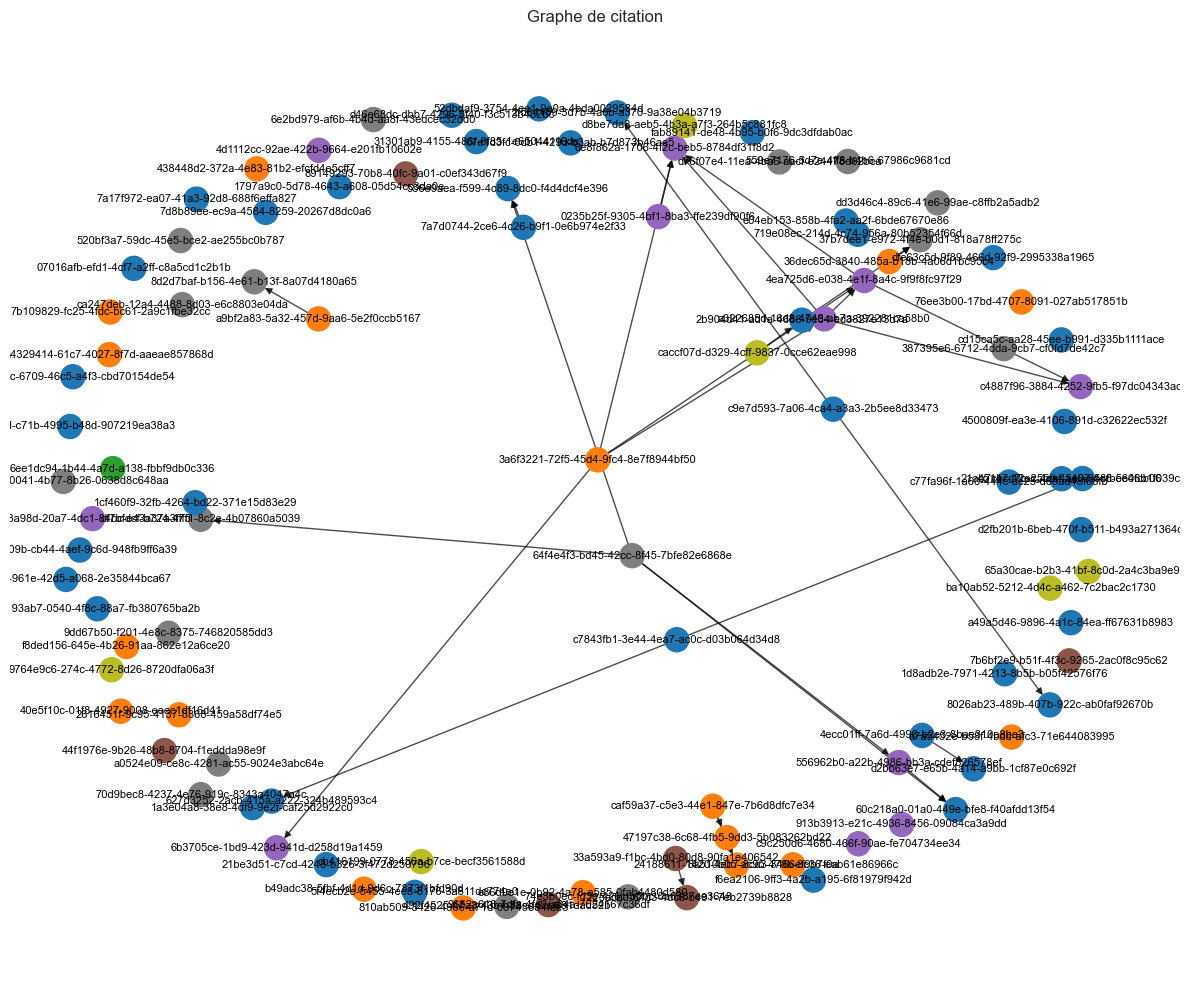

In [10]:
# Créer un objet GraphVisualizer
graph_viz = GraphVisualizer(citation_graph)

# Définir une taille maximale pour la visualisation (limitons aux nœuds les plus connectés)
max_nodes_to_visualize = 100

if citation_graph.number_of_nodes() > max_nodes_to_visualize:
    print(f"Le graphe est trop grand pour être visualisé entièrement. Affichage des {max_nodes_to_visualize} nœuds les plus connectés.")
    
    # Trouver les nœuds les plus connectés
    degree_dict = dict(citation_graph.degree())
    top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:max_nodes_to_visualize]
    top_node_ids = [node for node, degree in top_nodes]
    
    # Créer un sous-graphe
    subgraph = citation_graph.subgraph(top_node_ids)
    viz_graph = subgraph
else:
    viz_graph = citation_graph

# Visualiser le graphe avec la couleur des nœuds basée sur la classe
print("Visualisation du graphe de citation...")
# Créer un visualiseur pour le sous-graphe
sub_graph_viz = GraphVisualizer(viz_graph)
sub_graph_viz.visualize_graph(
    layout='spring',
    node_color_attribute='class_id',
    node_size_attribute=None,
    title='Graphe de citation'
)

## 6. Construction et analyse du graphe de co-autorat

In [4]:
# Créer un objet GraphBuilder
graph_builder = GraphBuilder(cleaned_docs)

# Construire le graphe de co-autorat
print("Construction du graphe de co-autorat...")
coauthorship_graph = graph_builder.build_coauthorship_graph()

print(f"Graphe de co-autorat construit avec {coauthorship_graph.number_of_nodes()} nœuds (auteurs) et {coauthorship_graph.number_of_edges()} arêtes (collaborations)")

# Statistiques de base sur le graphe de co-autorat
coauthor_stats = GraphStats(coauthorship_graph)
basic_stats = coauthor_stats.compute_basic_stats()

print("\nStatistiques de base du graphe de co-autorat:")
for key, value in basic_stats.items():
    print(f"- {key}: {value}")

# Trouver les auteurs avec le plus de collaborateurs
author_degrees = dict(coauthorship_graph.degree())
top_collaborators = sorted(author_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 des auteurs avec le plus de collaborateurs:")
for author, num_collaborators in top_collaborators:
    print(f"- {author}: {num_collaborators} collaborateurs")

Construction du graphe de co-autorat...
Graphe de co-autorat construit avec 81531 nœuds (auteurs) et 142373 arêtes (collaborations)

Statistiques de base du graphe de co-autorat:
- num_nodes: 81531
- num_edges: 142373
- density: 4.283683944663787e-05
- is_connected: False
- num_connected_components: 15267
- average_clustering: 0.6827356132351993
- diameter: 42

Top 10 des auteurs avec le plus de collaborateurs:
- br: 96 collaborateurs
- Lei Zhang: 63 collaborateurs
- Yang Liu: 57 collaborateurs
- Nassir Navab: 57 collaborateurs
- Jörg Becker: 55 collaborateurs
- Mario Piattini: 54 collaborateurs
- John Mylopoulos: 50 collaborateurs
- Kaoru Hirota: 50 collaborateurs
- Frank K. Soong: 48 collaborateurs
- John H. L. Hansen: 48 collaborateurs


In [6]:
# Sauvegarder ce graphe:
output_dir = "../data/processed/"
os.makedirs(output_dir, exist_ok=True)  # Créer le dossier s'il n'existe pas
graph_name = "coauthorship_graph"

# Sauvegarde en format GraphML (utile pour Gephi)
graphml_path = os.path.join(output_dir, f"{graph_name}.graphml")
nx.write_graphml(coauthorship_graph, graphml_path)
print(f"Graphe enregistré en GraphML : {graphml_path}")



# Sauvegarde en format Edgelist (format texte simple)
edgelist_path = os.path.join(output_dir, f"{graph_name}.edgelist")
nx.write_edgelist(coauthorship_graph, edgelist_path)
print(f"Graphe enregistré en Edgelist : {edgelist_path}")

# Sauvegarde en format JSON (structure exploitable)
json_path = os.path.join(output_dir, f"{graph_name}.json")
data = nx.node_link_data(coauthorship_graph)  # Convertir le graphe en format JSON
with open(json_path, "w", encoding="utf-8") as f:
    import json
    json.dump(data, f, indent=4)
print(f"Graphe enregistré en JSON : {json_path}")

Graphe enregistré en GraphML : ../data/processed/coauthorship_graph.graphml
Graphe enregistré en Edgelist : ../data/processed/coauthorship_graph.edgelist


C:\Users\DELL_7670\anaconda3\envs\network_analysis_ir\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


Graphe enregistré en JSON : ../data/processed/coauthorship_graph.json


## 7. Visualisation du graphe de co-autorat

Nombre de nœuds: 81531, Nombre d'arêtes: 142373
Le graphe de co-autorat est trop grand. Affichage des 50 auteurs les plus connectés.


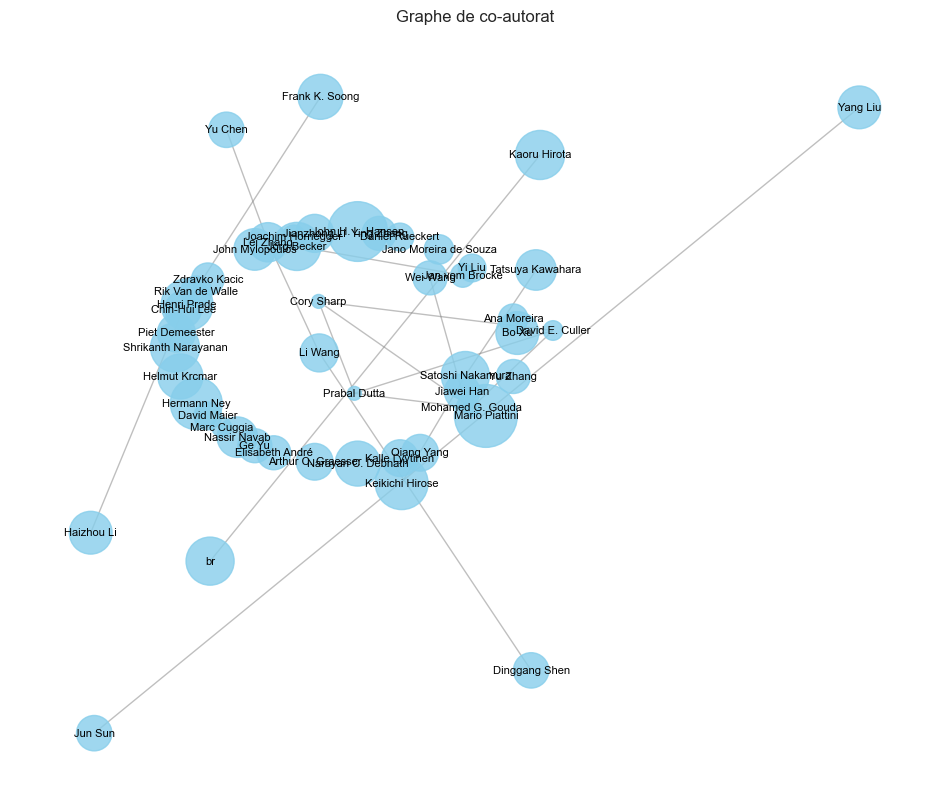

In [7]:


# Vérifier la taille du graphe avant de visualiser
max_authors_to_visualize = 50

print(f"Nombre de nœuds: {coauthorship_graph.number_of_nodes()}, Nombre d'arêtes: {coauthorship_graph.number_of_edges()}")

# Si le graphe est trop grand, on ne visualise que les 50 auteurs les plus connectés
if coauthorship_graph.number_of_nodes() > max_authors_to_visualize:
    print(f"Le graphe de co-autorat est trop grand. Affichage des {max_authors_to_visualize} auteurs les plus connectés.")

    # Sélectionner les auteurs avec le plus de collaborations
    author_degrees = dict(coauthorship_graph.degree())
    top_authors = sorted(author_degrees.items(), key=lambda x: x[1], reverse=True)[:max_authors_to_visualize]
    top_author_ids = [author for author, degree in top_authors]

    # Créer un sous-graphe
    subgraph = coauthorship_graph.subgraph(top_author_ids)
    viz_graph = subgraph
else:
    viz_graph = coauthorship_graph

# Vérifier si le sous-graphe est vide
if viz_graph.number_of_nodes() == 0:
    print("Aucun nœud à afficher dans le sous-graphe.")
else:
    # Choisir une mise en page efficace
    layout_method = 'kamada_kawai'  # Plus stable et rapide que spring_layout

    if layout_method == 'spring':
        pos = nx.spring_layout(viz_graph, seed=42, k=0.1, iterations=50)  # Moins d'itérations pour plus de rapidité
    elif layout_method == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(viz_graph)
    elif layout_method == 'circular':
        pos = nx.circular_layout(viz_graph)
    elif layout_method == 'spectral':
        pos = nx.spectral_layout(viz_graph)
    else:
        pos = nx.spring_layout(viz_graph, seed=42, k=0.1, iterations=50)

    # Déterminer la taille des nœuds en fonction du nombre de publications
    node_sizes = [viz_graph.nodes[n].get('num_papers', 1) * 50 for n in viz_graph.nodes]

    # Dessiner le graphe
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(viz_graph, pos, node_color='skyblue', node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(viz_graph, pos, width=1.0, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(viz_graph, pos, font_size=8)

    plt.title("Graphe de co-autorat")
    plt.axis('off')
    plt.show()


## 8. Détection de communautés

 Détection de communautés avec l'algorithme de Louvain...
Nombre de communautés détectées: 37118

 Top 5 des plus grandes communautés:
   - Communauté 404: 68 nœuds
   - Communauté 2061: 50 nœuds
   - Communauté 487: 50 nœuds
   - Communauté 5170: 47 nœuds
   - Communauté 492: 43 nœuds
 Sélection des 50 nœuds les plus importants pour la visualisation...
 Visualisation des communautés avec 50 nœuds et 11 arêtes.


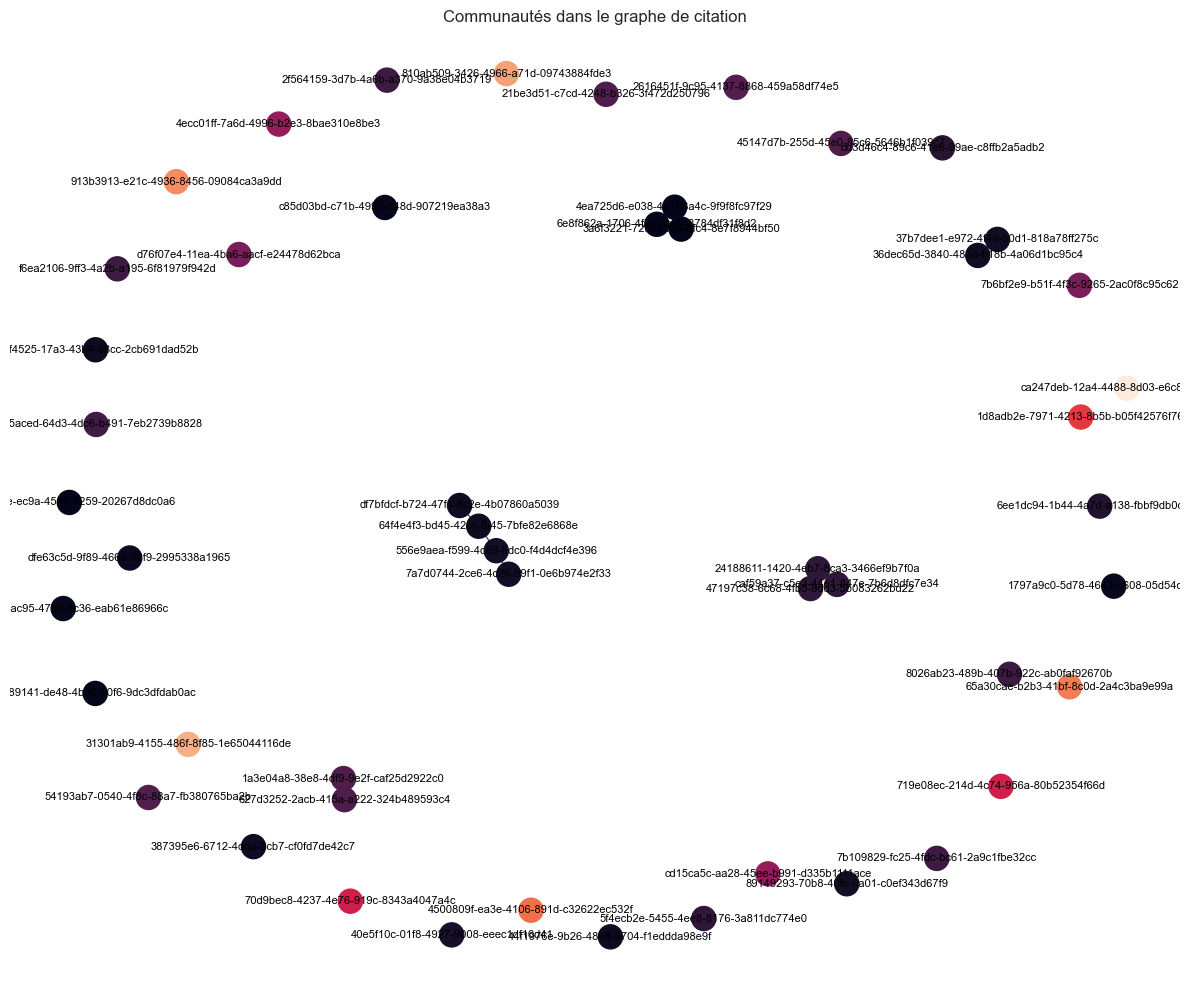

In [12]:
# Vérifier que citation_graph est bien défini
if 'citation_graph' not in globals():
    print(" Erreur : Le graphe citation_graph n'a pas été défini. Vérifiez la construction du graphe.")
else:
    print(" Détection de communautés avec l'algorithme de Louvain...")

    max_nodes_to_visualize = 50  # Nombre max de nœuds à afficher

    # Vérifier que le graphe n'est pas vide
    if citation_graph.number_of_edges() > 0:
        # Convertir en graphe non dirigé pour Louvain
        undirected_graph = citation_graph.to_undirected()

        # Appliquer l'algorithme de Louvain
        partition = community_louvain.best_partition(undirected_graph)

        # Compter le nombre de communautés
        communities = {}
        for node, comm_id in partition.items():
            if comm_id not in communities:
                communities[comm_id] = []
            communities[comm_id].append(node)

        print(f"Nombre de communautés détectées: {len(communities)}")

        # Afficher les plus grandes communautés
        community_sizes = {comm_id: len(nodes) for comm_id, nodes in communities.items()}
        top_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]

        print("\n Top 5 des plus grandes communautés:")
        for comm_id, size in top_communities:
            print(f"   - Communauté {comm_id}: {size} nœuds")

        # Ajouter l'attribut 'community' aux nœuds du graphe
        nx.set_node_attributes(undirected_graph, partition, 'community')

        # Vérifier si le graphe est trop grand pour la visualisation
        if undirected_graph.number_of_nodes() > max_nodes_to_visualize:
            print(f" Sélection des {max_nodes_to_visualize} nœuds les plus importants pour la visualisation...")

            # Trier les nœuds par degré et sélectionner les plus connectés
            node_degrees = dict(undirected_graph.degree())
            top_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:max_nodes_to_visualize]

            # Créer un sous-graphe
            community_graph = undirected_graph.subgraph(top_nodes)

            # Filtrer les communautés
            sub_partition = {node: partition[node] for node in top_nodes}
            communities_to_viz = {
                comm_id: [node for node in nodes if node in top_nodes]
                for comm_id, nodes in communities.items()
            }
        else:
            community_graph = undirected_graph
            sub_partition = partition
            communities_to_viz = communities

        # Vérifier si le sous-graphe contient des nœuds
        if community_graph.number_of_nodes() == 0 or community_graph.number_of_edges() == 0:
            print("Le sous-graphe est vide, aucune visualisation possible.")
        else:
            print(f" Visualisation des communautés avec {community_graph.number_of_nodes()} nœuds et {community_graph.number_of_edges()} arêtes.")

            # Vérifier si les attributs sont bien assignés
            node_attributes = nx.get_node_attributes(community_graph, 'community')
            if not node_attributes:
                print(" Attention : Aucun attribut 'community' trouvé sur les nœuds ! Vérifiez l'assignation.")

            # Visualiser avec des couleurs basées sur les communautés
            community_viz = GraphVisualizer(community_graph)
            community_viz.visualize_graph(
                layout='spring',
                node_color_attribute='community',
                title='Communautés dans le graphe de citation'
            )
    else:
        print("Le graphe n'a pas d'arêtes, impossible de détecter des communautés.")



## 9. Graphe bipartite document-auteur

In [15]:
# Construire le graphe biparti document-auteur
print("Construction du graphe biparti document-auteur...")
bipartite_graph = graph_builder.build_document_author_graph()

print(f"Graphe biparti construit avec {bipartite_graph.number_of_nodes()} nœuds et {bipartite_graph.number_of_edges()} arêtes")

# Compter le nombre de documents et d'auteurs
num_docs = sum(1 for n, attr in bipartite_graph.nodes(data=True) if attr.get('type') == 'document')
num_authors = sum(1 for n, attr in bipartite_graph.nodes(data=True) if attr.get('type') == 'author')

print(f"Le graphe contient {num_docs} documents et {num_authors} auteurs")

# Calculer la connectivité du graphe
bipartite_stats = GraphStats(bipartite_graph)
basic_stats = bipartite_stats.compute_basic_stats()

print("\nStatistiques de base du graphe biparti:")
for key, value in basic_stats.items():
    if key not in ['average_clustering', 'diameter']:  # Ces mesures ne sont pas adaptées aux graphes bipartis
        print(f"- {key}: {value}")

Construction du graphe biparti document-auteur...
Graphe biparti construit avec 122127 nœuds et 115753 arêtes
Le graphe contient 40596 documents et 81531 auteurs

Statistiques de base du graphe biparti:
- num_nodes: 122127
- num_edges: 115753
- density: 1.552181237296791e-05
- is_connected: False
- num_connected_components: 15267
